In [2]:
#Connect to your google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#checking the available files
%cd /gdrive/My\ Drive/digit-recognizer
!ls -ltr

/gdrive/My Drive/digit-recognizer
total 1472476
-rw------- 1 root root   76775041 Mar 23  2023  train.csv
-rw------- 1 root root   51118296 Mar 23  2023  test.csv
-rw------- 1 root root     240909 Mar 23  2023  sample_submission.csv
-rw------- 1 root root         68 May  8 06:55 'kaggle (1).json'
-rw------- 1 root root 1379678841 May  8 07:02  fruits.zip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import random

from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from pactools.grid_search import GridSearchCVProgressBar

from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [6]:
#%%timeit -n 10
# 10 loops, best of 3: 7.07 s per loop
mnist_train = pd.read_csv("/content/drive/MyDrive/digit-recognizer/train.csv")
mnist_test  = pd.read_csv("/content/drive/MyDrive/digit-recognizer/test.csv")

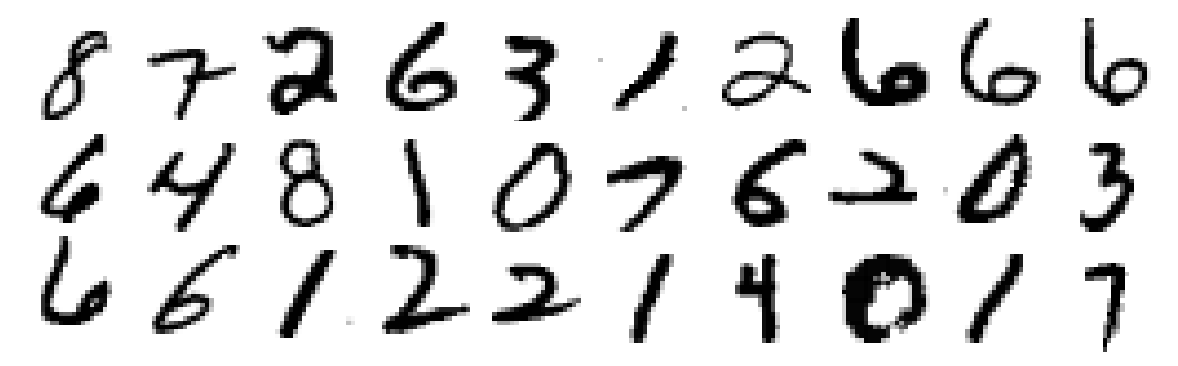

In [7]:
# VISUALIZE DATA
samples = mnist_train.iloc[5000:5030,1:].values
plt.figure(figsize=(15,4.5))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(samples[i].reshape((28,28)),cmap=plt.cm.binary)
    plt.axis('off')
plt.subplots_adjust(wspace=-0.1, hspace=-0.1)
plt.show()

In [8]:
mnist_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
print(mnist_train.shape, mnist_test.shape)

(42000, 785) (28000, 784)


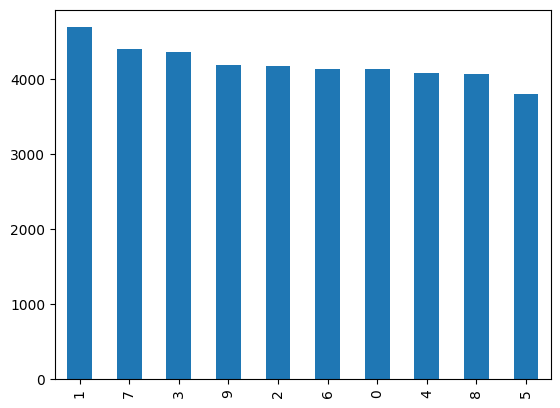

In [10]:
#%%timeit
#345 ms
_ = mnist_train['label'].value_counts().plot(kind='bar')
plt.show()

In [11]:
#%%time
#Wall time: 14.6 s
X_raw = mnist_train.drop(['label'], axis = 1, inplace = False)
y = mnist_train['label']

In [12]:
#Data is being Scaled now to make it uniform
#%%time
# Wall time: 28.5 s
arr = X_raw.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(arr)
X = pd.DataFrame(x_scaled)

In [13]:
X.max()

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
779    1.0
780    0.0
781    0.0
782    0.0
783    0.0
Length: 784, dtype: float64

In [14]:
X_1, X_test, y_1, y_test = train_test_split(X,y,test_size = 0.25, random_state = 10)
X_train, X_cv, y_train, y_cv = train_test_split(X_1,y_1,test_size = 0.20, random_state = 10)
print(X_train.shape, X_test.shape, X_cv. shape, y_train.shape, y_test.shape, y_cv.shape)

(25200, 784) (10500, 784) (6300, 784) (25200,) (10500,) (6300,)


In [15]:
#%%time
# Wall time: 1min 54s
maxDepth = [4,6,8,10,12,15,20,30,50,80, 120]
trainAcc = []
CVAcc = []
for depth in tqdm(maxDepth):
    clfDT = DecisionTreeClassifier(criterion='gini',max_depth = depth)
    clfDT.fit(X_train, y_train)
    y_predDTtrain = clfDT.predict(X_train)
    y_predDTcv = clfDT.predict(X_cv)
    accTr = accuracy_score(y_train, y_predDTtrain)
    accCv = accuracy_score(y_cv, y_predDTcv)
    trainAcc.append(accTr)
    CVAcc.append(accCv)

100%|██████████| 11/11 [01:27<00:00,  7.94s/it]


In [16]:
print(trainAcc)
print(CVAcc)

[0.6329761904761905, 0.7385714285714285, 0.8384920634920635, 0.9097222222222222, 0.9556746031746032, 0.9851190476190477, 0.9957936507936508, 0.9993253968253968, 1.0, 1.0, 1.0]
[0.6395238095238095, 0.7398412698412699, 0.8134920634920635, 0.844920634920635, 0.8503174603174604, 0.8552380952380952, 0.849047619047619, 0.8511111111111112, 0.8503174603174604, 0.8504761904761905, 0.8439682539682539]


In [19]:
def plotCVandTrainAccuracyAndError(CVAcc,trainAcc,maxDepth):
    fig = plt.figure(figsize = (10,5))
    ax = plt.subplot(1,2,1)
    ax.set_xlabel('Maximum Depth', fontsize = 10)
    ax.set_ylabel('Accuracy', fontsize = 10)
    ax.set_title('Check fitting of model', fontsize = 10)

    plt.plot(maxDepth,CVAcc,label='CV Accuracy')
    plt.plot(maxDepth,trainAcc,label='train Accuracy')
    ax.legend()

    trainError = [1-x for x in trainAcc]
    CVError    = [1-x for x in CVAcc]
    ax = plt.subplot(1,2,2)
    ax.set_xlabel('Maximum Depth', fontsize = 10)
    ax.set_ylabel('Error', fontsize = 10)
    ax.set_title('Check fitting of model', fontsize = 10)

    plt.plot(maxDepth,CVError,label='CV Error')
    plt.plot(maxDepth,trainError,label='train Error')
    ax.legend()

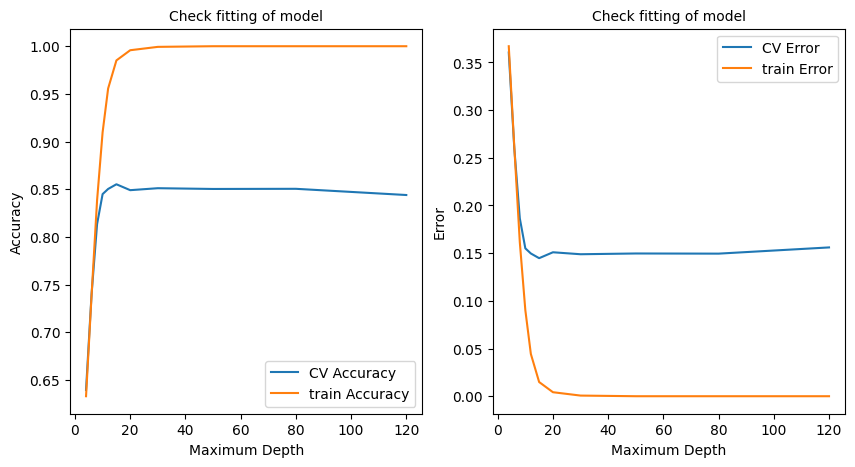

In [24]:
plotCVandTrainAccuracyAndError(CVAcc,trainAcc,maxDepth)

In [25]:
clfDT = DecisionTreeClassifier(criterion='gini',max_depth = 15)
clfDT.fit(X_train, y_train)
y_pred = clfDT.predict(X_test)

print("Final Accuracy DT: ",accuracy_score(y_test,y_pred))

Final Accuracy DT:  0.8488571428571429
